In [3]:
!git add .
!git commit -m ""
!git pull
#!git push 

Aborting commit due to empty commit message.


Updating 973f2a8..864556c


error: Your local changes to the following files would be overwritten by merge:
	Sports_Misinformation_Tool/SportsNewsTool.ipynb
Please commit your changes or stash them before you merge.
Aborting


In [11]:
# !git rm --cached glove.6B.300d.txt
# !git commit -m "Stop tracking glove.6B.300d.txt"
#!git status
#!git push

# !git filter-repo --path Sports_Misinformation_Tool/glove.6B.300d.txt --invert-paths
# !git rev-list --objects --all | grep "glove.6B.300d.txt"

# !git reflog expire --expire=now --all
# !git gc --prune=now --aggressive
#!git remote add origin https://github.com/thernandez7/Sports_Misinformation_Tool.git
#!git push origin main --force

#!git branch --set-upstream-to=origin/main main

branch 'main' set up to track 'origin/main'.


## Sports Misinformation Classification Tool

In [19]:
import mysql.connector
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

In [5]:
username = 'root'  
password = 'password'
host = 'localhost' 
database = 'sports_misinfo_db'

connection = mysql.connector.connect(
    host=host,
    user=username,
    password=password,
    database=database
)

if connection.is_connected():
    print("Connected to the database successfully!")

engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}/{database}", echo=False)

Connected to the database successfully!


### Simulate Tool 

In [59]:
team_or_player = input("Enter the team or player's name: ")

query = f"SELECT * FROM articles WHERE team_or_player LIKE '%{team_or_player}%' ORDER BY trust_score DESC" #search for entered name/team in the title 
df_result = pd.read_sql(query, con=engine, params={'team_or_player': team_or_player})

#get results
if not df_result.empty:
    print()
    print(f"Articles related to {team_or_player}:")
    for index, row in df_result.iterrows():
        print(f"  Headline: {row['team_or_player']}")
        print(f"  Source: {row['source']}\tPublished Date: {row['publication_date']}")
        print(f"  Article Link: {row['link']}")
        print(f"  Credible or Uncredible: {row['classification']}")
        print(f"  Credible Probability: {row['trust_score']*100}%")
        print()
        print("-" * 50)
else:
    print(f"No articles found for {team_or_player}.")

Enter the team or player's name:  Patrick 



Articles related to Patrick :
  Headline: Patrick Mahomes and Chiefs win at the buzzer again, topping Panthers 30-27 on Shrader's field goal
  Source: ABC News: Sports	Published Date: 2024-11-24
  Article Link: https://abcnews.go.com/Sports/wireStory/patrick-mahomes-chiefs-win-buzzer-topping-panthers-30-116184380
  Credible or Uncredible: credible
  Credible Probability: 74.0%

--------------------------------------------------
  Headline: Patrick Mahomes fined $14,069 for violent gesture
  Source: Yahoo! Sports - News, Scores, Standings, Rumors, Fantasy Games	Published Date: 2024-11-23
  Article Link: https://sports.yahoo.com/patrick-mahomes-fined-14-069-212416146.html
  Credible or Uncredible: credible
  Credible Probability: 72.0%

--------------------------------------------------
  Headline: Patrick Mahomes fined $14K by NFL for ‘violent gesture’
  Source: NY Post Sports – Latest News, Scores, Stats & Videos	Published Date: 2024-11-24
  Article Link: https://nypost.com/2024/11/24

### Get Article Entries from RSS Feeds

In [5]:
# # reddit API - collected 1876 posts
# import csv
# import praw
# from datetime import datetime


# reddit = praw.Reddit(
#     client_id='w-kwRyPigyjYeG9DOiDc8g', 
#     client_secret='ZeDsvNH2YlpVH7F9wEWPkt5wkjLzqA',  
#     user_agent='sports_misinfo_script'  
# )

# subreddit = reddit.subreddit('sports+fantasyfootball') #2 subreddits 

# recent_posts = []
# for post in subreddit.new(limit= 5000):
#     created_date = datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S')
#     recent_posts.append({
#         'title': post.title,
#         'score': post.score,
#         'url': post.url,
#         'id': post.id,
#         'author': str(post.author),
#         'text': post.selftext,
#         'created_date': created_date,
#         'num_comments': post.num_comments,
#         'subreddit': post.subreddit.display_name,

#     })

# print(f"Fetched {len(recent_posts)} posts")

# for i, post in enumerate(recent_posts[:5]):
#     print(f"{i+1}. Title: {post['title']} | Score: {post['score']} | URL: {post['url']}")


# #-------------------------------
# #Save the data to a csv file
# fieldnames = ['title', 'score', 'url', 'id', 'author', 'text', 'created_date', 'num_comments', 'subreddit']

# with open('recent_sports_reddit_posts.csv', mode='w', newline='', encoding='utf-8') as csv_file:
#     writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

#     writer.writeheader()

#     for post in recent_posts:
#         writer.writerow(post)

# print("Data successfully saved to 'recent_sports_reddit_posts.csv'")
# print("Data saved")


In [21]:
import feedparser
import requests
from bs4 import BeautifulSoup

#add urls to this list to parse
url_list = [
        # #MBFC High Credibility-9 
        "https://www.espn.com/espn/rss/news", #ESPN top headlines
        "https://deadspin.com/rss/", #Deadspin 
        "https://feeds.abcnews.com/abcnews/sportsheadlines", #ABC news- espn sports
        "https://rss.nytimes.com/services/xml/rss/nyt/Sports.xml", #NYT
        "https://www.nytimes.com/athletic/rss/news/", #The Athletic- acquired by NYT
        "https://www.mlb.com/feeds/news/rss.xml", #MLB news 
        "https://www.reutersagency.com/feed/?best-topics=sports&post_type=best", # Reuters
        "https://sports.yahoo.com/rss/", #Yahoo News
        "https://www.cbssports.com/rss/headlines/", #CBS sports general headlines 

        #MBFC questionable sources or medium credibility- 5
        "https://notthebee.com/feed", #not the bee
        "https://uproxx.com/sports/feed/", #uproxx   
        "https://www.vibe.com/c/news/sports/feed/", #The vibe - medium cred 
        "https://moxie.foxnews.com/google-publisher/sports.xml", #fox news 
        "https://nypost.com/sports/feed/", #NY post - medium cred

        #NO MBFC RATING -11 
        "https://www.sportscollectorsdaily.com/feed/", #Sports Collectors Daily 
        "https://news.sportslogos.net/feed/", #SportsLogos.Net
        "https://www.sportingnews.com/us/rss", #sportingnews.com
        "https://www.sportskeeda.com/feed",#sportskeeda.com
        "https://sportsweez.com/feed/", #sportsweez
        "https://sportsbrackets.net/feed/", #sportsbracket
        "https://21sports.com/feed/", # 21 sports
        "https://www.essentiallysports.com/feed/", #essentiallysports
        "https://boxingnewsonline.net/feed/", #boxing news
        "https://www.thecoldwire.com/feed/", #the cold wire
        "https://sportsdark.com/feed/", #sports dark
         
]
    
entries = [] #list of dictionaries

#--------------DEFINE FUNCTION TO SCRAPE-------------------
def scrape_article_content(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")

        #extract content from common tags
        article_body = (
            soup.find("article") or
            soup.find("div", {"class": "post-content"}) or
            soup.find("div", class_="article-body") or
            soup.find("div", class_="article-content") or
            soup.find("section", class_="article-section") or
            soup.find("div", class_="main-content") or
            soup.find("div", class_="content-body")
        )
        
        if article_body:
            paragraphs = article_body.find_all("p")
        else:
            paragraphs = soup.find_all("p")

        #join all paragraphs into a single string
        article_content = " ".join(p.get_text() for p in paragraphs)
        return article_content.strip() if article_content else "No content found"

    except Exception as e:
        print(f"Failed to scrape content from {url}: {e}")
        return "Failed to fetch content"


#run the function to collect feeds and scrape
for url in url_list:
    feed = feedparser.parse(url)
    #feed_title= feed.feed.title
    feed_title = getattr(feed.feed, "title", None)

    
    for entry in feed.entries:
        entry_title = getattr(entry, "title", None)
        entry_link = getattr(entry, "link", None)
        entry_published_date = getattr(entry, "published", None)
        entry_summary = getattr(entry, "summary", None)
        entry_content = scrape_article_content(entry_link) #scrape
        
        entries.append({
            "feed_title": feed_title,
            "entry_title": entry_title,
            "entry_link": entry_link,
            "entry_published_date": entry_published_date,
            "entry_summary": entry_summary,
            "entry_content": entry_content,
        })

df = pd.DataFrame(entries)
#print(df)

df.to_csv('RSS_sports_feeds_12-01.csv', index=False)

Failed to scrape content from https://www.espn.com/college-football/story/_/id/42708984/texas-longhorns-top-texas-aggies-play-sec-title: 403 Client Error: Forbidden for url: https://www.espn.com/college-football/story/_/id/42708984/texas-longhorns-top-texas-aggies-play-sec-title
Failed to scrape content from https://www.espn.com/mens-college-basketball/story/_/id/42707414/legendary-st-john-basketball-coach-lou-carnesecca-dies-99: 403 Client Error: Forbidden for url: https://www.espn.com/mens-college-basketball/story/_/id/42707414/legendary-st-john-basketball-coach-lou-carnesecca-dies-99
Failed to scrape content from https://www.espn.com/college-football/story/_/id/42703166/police-probing-use-pepper-spray-ohio-state-michigan-melee: 403 Client Error: Forbidden for url: https://www.espn.com/college-football/story/_/id/42703166/police-probing-use-pepper-spray-ohio-state-michigan-melee
Failed to scrape content from https://www.espn.com/college-football/story/_/id/42709574/billy-napier-calls

### Attempt to Scrape Links without RSS Feeds- not very effective 

In [9]:
# import requests
# from bs4 import BeautifulSoup
# import pandas as pd

# uncredible_urls = [
#     "https://www.tellerreport.com/sports",
#     "https://www.newsbreak.com/mountain-view-ca-sports",
#     "https://newsrnd.com/sports",
#     "https://baltimorecitywire.com/stories/tag/53-sports"
# ]

# # Function to scrape article details
# def scrape_article(url):
#     try:
#         response = requests.get(url, timeout=10)
#         response.raise_for_status()
#         soup = BeautifulSoup(response.content, "html.parser")

#         # Extract the article title
#         title = soup.find("h1").get_text() if soup.find("h1") else soup.title.get_text()

#         # Extract the publication date (common in <time> or meta tags)
#         date = soup.find("time")
#         if date:
#             publication_date = date.get("datetime") or date.get_text()
#         else:
#             date_meta = soup.find("meta", {"name": "article:published_time"})
#             publication_date = date_meta["content"] if date_meta else "No date found"

#         # Extract the article content
#         content_container = (
#             soup.find("article") or
#             soup.find("div", class_=["post-content", "article-body", "article-content", "content-body"])
#         )
#         if content_container:
#             paragraphs = content_container.find_all("p")
#         else:
#             paragraphs = soup.find_all("p")

#         content = "\n".join(p.get_text() for p in paragraphs)

#         return {
#             "Title": title.strip(),
#             "Publication Date": publication_date.strip(),
#             "Content": content.strip()[:500] + "...",
#             "Link": url
#         }

#     except Exception as e:
#         print(f"Failed to scrape {url}: {e}")
#         return None

# articles = []
# for url in uncredible_urls:
#     print(f"Scraping: {url}")
#     article_details = scrape_article(url)
#     if article_details:
#         articles.append(article_details)

# for article in articles:
#     print("\n--- Article ---")
#     print(f"Title: {article['Title']}")
#     print(f"Date: {article['Publication Date']}")
#     print(f"Content Preview: {article['Content']}")
#     print(f"Link: {article['Link']}\n")

# df = pd.DataFrame(articles)
# output_file = "scraped_uncredible_articles.csv"
# df.to_csv(output_file, index=False)
# print(f"\nResults saved to {output_file}")

### Feature Computation Functions - use some for labeling and others for model

In [27]:
# !pip install textstat
from transformers import pipeline
import string
from textstat import flesch_reading_ease
import textstat
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()


#functions for each feature we are considering
def word_count(text):
    return len(text.split())

def char_count(text):
    return len(text)

def avg_word_length(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words) if words else 0

def all_capitalized_word_count(text):
    return sum(1 for word in text.split() if word.isupper())

def punctuation_count(text):
    return sum(1 for char in text if char in string.punctuation)

def exclamation_count(text):
    return text.count("!")

def question_mark_count(text):
    return text.count("?")

def readability_score(text): #high score = easier readability
    return flesch_reading_ease(text)

def smog_index(text): #readability based on the number of complex words (3+ syllables)
    return textstat.smog_index(text)

def count_quotation_pairs(text): 
    double_quotes = re.findall(r'"[^"]+"', text) #Finds all sections of text in double quotes
    return len(double_quotes)

def variety_of_vocabularity(text):
    words = text.split()
    unique_words = set(words)
    return len(unique_words) / len(words) if words else 0


sensational_words = ["shocking","shock", "amazing", "unbelievable", "you won’t believe", "incredible", "stunning",\
                    "astounding", "breathtaking", "outstanding", "thrilling", "must see", "terrible", "awful",\
                     "fantastic", "horrible", "remarkable"]
def count_sensational_words(text):
    text = text.lower()
    return sum(1 for word in sensational_words if word in text)


absolute_words = ["always", "never", "clearly", "obviously", "definitely", "everyone", "nobody", "all",\
              "none", "blatantly", "undoubtedly", "must", "should"]
def count_absolute_words(text):
    words = text.lower().split()
    return sum(1 for word in words if word in absolute_words)


factuality_words = ["proven", "irrefutable", "unarguable", "unquestionably", "certainly", "definitely",\
                    "undeniable"]
def count_factuality_words(text):
    words = text.lower().split()
    return sum(1 for word in words if word in factuality_words)


subjective_words = ["believe", "think", "feel", "prefer", "seems", "wish"]
def subjectivity_score(text):
    words = text.lower().split()
    subjective_count = sum(1 for word in words if word in subjective_words)
    return subjective_count / len(words) if len(words) > 0 else 0

objective_words = ["reported", "measured", "confirmed", "analyzed", "observed", "recorded",\
                   "found", "documented", "verified", "tested", "studied", "calculated", "noted",\
                   "established", "evidence", "fact", "data", "statistics", "demonstrated", "shown",\
                   "results", "result", "evidence-based", "peer-reviewed", "sampled", "quantified",\
                   "evaluated", "experimented", "investigated"]
def objective_score(text):
    words = text.lower().split()
    objective_count = sum(1 for word in words if word in objective_words)
    return objective_count / len(words) if len(words) > 0 else 0


def count_numerics(text):
    numerical_count = len(re.findall(r'\d+', text)) 
    return numerical_count


pipe_finnews = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
def sentiment(text):
    result = pipe_finnews(text)
    if  result[0]["label"] =='neutral':
        return 0
    elif result[0]["label"] =='positive':
        return 1
    elif result[0]["label"] =='negative':
        return -1


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tizia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Define Labeling Heuristic Function

In [29]:
def calculate_credibility_score(headline, source_credibility):
    # Source credibility weights
    SOURCE_CREDIBILITY = {
        'high': 1.0,
        'unknown': 0,
        'medium': -0.5,
        'low': -1.0
    }
    
    # Top heuristics and their weights (based on the difference column)
    heuristics = {
        'smog_index': {
            'weight': 9.448,  # From the Difference column
            'true_avg': 0.124, # From the True_Avg column
            'false_avg': 1.169 # From the False_Avg column
        },
        'factuality_words_count': {
            'weight': 8.200,  
            'true_avg': 0.000263,
            'false_avg': 0.002158
        },
        'exclamation_count': {
            'weight': 6.326, 
            'true_avg': 0.0192,
            'false_avg': 0.1215
        },
        'subjectivity_score': {
            'weight': 4.308,  
            'true_avg': 0.000373,
            'false_avg': 0.001606
        },
        'question_mark_count': {
            'weight': 4.285,  
            'true_avg': 0.0327,
            'false_avg': 0.1403
        },
        'count_numerics': {
            'weight': 3.089,  
            'true_avg': 0.7496,
            'false_avg': 0.2427
        }
    }   
    
    # Calculate metrics for each of the heuristics we're using
    metrics = {
        'smog_index': smog_index(headline),
        'factuality_words_count': count_factuality_words(headline),
        'exclamation_count': exclamation_count(headline),
        'subjectivity_score': subjectivity_score(headline),
        'question_mark_count': question_mark_count(headline),
        'count_numerics': count_numerics(headline)
    }

    # Initialize the credibility score
    credibility_score = 0
    
    # Calculate scores for each heuristic
    for metric, values in heuristics.items():
        true_avg = values['true_avg']
        false_avg = values['false_avg']
        weight = values['weight']
        current_value = metrics[metric]
        
        # Calculate which average the current value is closer to
        dist_to_true = abs(current_value - true_avg)
        dist_to_false = abs(current_value - false_avg)
        
        # Calculate percentage difference from the midpoint
        midpoint = (true_avg + false_avg) / 2            
        percent_diff = abs(current_value - midpoint) / midpoint
        
        # Add or subtract from score based on which average it's closer to
        if dist_to_true < dist_to_false:
            credibility_score += weight * percent_diff
        else:
            credibility_score -= weight * percent_diff
        
        # print(f"{metric}: {current_value:.4f}\n\tWeight: {weight:.2f}\n\tPercent Difference: {percent_diff:.4f}\n\tCredibility Score: {credibility_score:.2f}")
    
    # Add source credibility modifier
    if source_credibility: 
        source_credibility_score = SOURCE_CREDIBILITY.get(source_credibility.lower(), SOURCE_CREDIBILITY['unknown'])
        weight = 10
        credibility_score += (source_credibility_score * weight)
        # print(f"source_credibility: {source_credibility_score:.2f}\n\tWeight: {weight:.2f}\n\tCredibility Score: {credibility_score:.2f}")

    return credibility_score


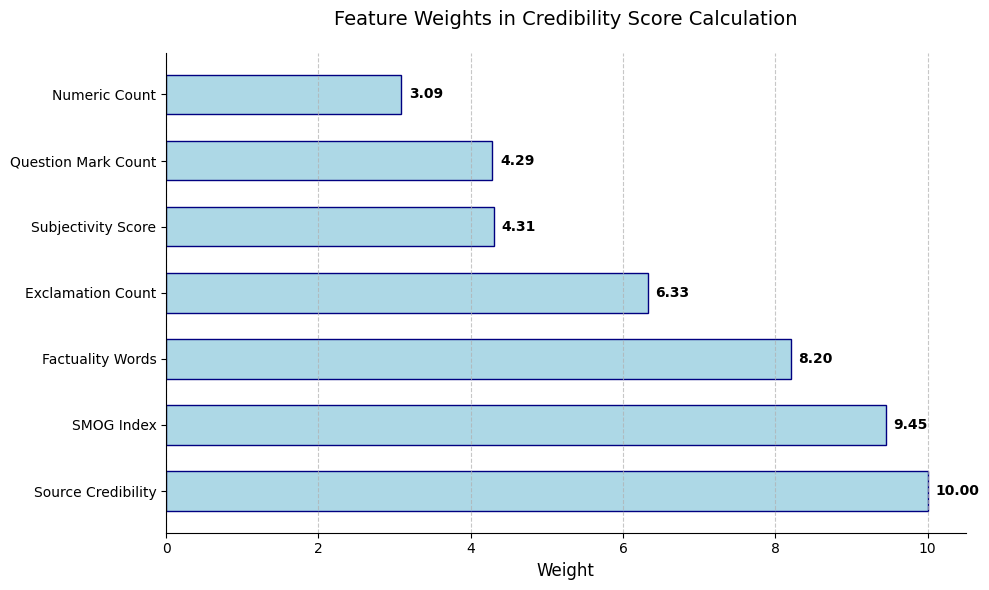

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Create data
features = {
    'Source Credibility': 10.0,
    'SMOG Index': 9.448,
    'Factuality Words': 8.200,
    'Exclamation Count': 6.326,
    'Subjectivity Score': 4.308,
    'Question Mark Count': 4.285,
    'Numeric Count': 3.089
}

# Create DataFrame
df = pd.DataFrame(list(features.items()), columns=['Feature', 'Weight'])

# Create horizontal bar chart with improved styling
plt.figure(figsize=(10, 6))
bars = plt.barh(df['Feature'], df['Weight'], 
                color='lightblue',  # Change bar color
                edgecolor='navy',   # Add edge color
                height=0.6)         # Adjust bar height

# Customize appearance
plt.xlabel('Weight', fontsize=12)
plt.title('Feature Weights in Credibility Score Calculation', 
          fontsize=14, pad=20)

# Add weight values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}', 
             ha='left', va='center', 
             fontweight='bold',
             fontsize=10)

# Customize grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Define Source credibilty of each source and run Labeling Heuristic Function on RSS Feed Data

In [31]:
#------------------------Determine source credibility-------------------------------------------

all_articles_df = pd.read_csv('All_RSS_articles.csv')
print(all_articles_df["feed_title"].unique())
    
high_cred= [
    'www.espn.com - TOP',
    'Deadspin > Sports News Without Fear, Favor or Compromise',
    'Yahoo! Sports - News, Scores, Standings, Rumors, Fantasy Games',
    'MLB News',
    'ABC News: Sports',
    'Latest Headlines- The Athletic',
    'NYT > Sports',
    'CBSSports.com Headlines',
]

medium_cred=[
    'Sports', #vibe
    'NY Post Sports – Latest News, Scores, Stats & Videos' 'ABC News: Sports',
]  

low_cred=[
    'Sports – UPROXX',
    'Not the Bee',
    'Latest Sports News Today on Fox News', #foxnews.com
]

no_cred=[
    'SportsLogos.Net News',
    'Sporting News RSS', 
    'Sports Weez', 
    'Sports Brackets',
    '21Sports.com', 
    'Boxing News', 
    'The Cold Wire', 
    'Sportsdark',
    'EssentiallySports', 
    'Sportskeeda', 
    'Sports Collectors Daily',
    'FOX Sports Digital', #foxsports.com
]

def determine_source_credibility(feed_title):
    if feed_title in high_cred:
        return "high"
    elif feed_title in medium_cred:
        return "medium"
    elif feed_title in low_cred:
        return "low"
    else:
        return "unknown"  

['www.espn.com - TOP'
 'Deadspin > Sports News Without Fear, Favor or Compromise'
 'ABC News: Sports' 'NYT > Sports' 'Latest Headlines - The Athletic'
 'MLB News'
 'Yahoo! Sports - News, Scores, Standings, Rumors, Fantasy Games'
 'CBSSports.com Headlines' 'Not the Bee' 'Sports – UPROXX' 'Sports'
 'Latest Sports News Today on Fox News'
 'NY Post Sports – Latest News, Scores, Stats & Videos'
 'Sports Collectors Daily' 'SportsLogos.Net News' 'Sporting News RSS'
 'Sports Weez' '21Sports.com' 'EssentiallySports' 'Boxing News'
 'The Cold Wire' 'Sportsdark' 'Sports Brackets' 'Sportskeeda'
 'FOX Sports Digital']


In [86]:
#Create a new column for source_credibility based on the feed_title
all_articles_df["source_credibility"] = all_articles_df["feed_title"].apply(determine_source_credibility)


CREDIBLE_VALUE= 0 
credibility_scores = []
credibility_labels = []
for index, row in all_articles_df.iterrows():
    #get the headline and source_credibility
    headline = row["entry_title"]
    source_credibility = row["source_credibility"]
    
    #Calculate the credibility score 
    score= calculate_credibility_score(headline, source_credibility)
    credibility_scores.append(score) #add to list

    if score>= CREDIBLE_VALUE:
        credibility_labels.append("credible")
    else:
        credibility_labels.append("uncredible")


all_articles_df["credibility_score"] = credibility_scores
all_articles_df["credibility_label"] = credibility_labels

all_articles_df.to_csv("labeled_RSS_posts.csv")
print("saved")

saved


### run Labeling Heuristic Function on EURO Data to evaluate performance

In [21]:
all_articles_df = pd.read_csv('real_european.csv')
all_articles_df = all_articles_df[all_articles_df["tweet"].notna()]

#Create a new column for source_credibility based on the tweet- always 'unknown' since not news
all_articles_df["source_credibility"] = "unknown"

CREDIBLE_VALUE= 0 
credibility_scores = []
credibility_labels = []
for index, row in all_articles_df.iterrows():
    #get the headline and source_credibility
    headline = row["tweet"]
    source_credibility = row["source_credibility"]
    
    #Calculate the credibility score 
    score= calculate_credibility_score(headline, source_credibility)
    credibility_scores.append(score) #add to list

    if score>= CREDIBLE_VALUE:
        credibility_labels.append("credible")
    else:
        credibility_labels.append("uncredible")


all_articles_df["credibility_score"] = credibility_scores
all_articles_df["credibility_label"] = credibility_labels

all_articles_df.to_csv("testing_labeling_on_euro_real.csv")
print("saved")

saved


In [23]:
all_articles_df = pd.read_csv('fake_european.csv')
all_articles_df = all_articles_df[all_articles_df["tweet"].notna()]

#Create a new column for source_credibility based on the tweet- always 'unknown' since not news
all_articles_df["source_credibility"] = "unknown"

CREDIBLE_VALUE= 0 
credibility_scores = []
credibility_labels = []
for index, row in all_articles_df.iterrows():
    #get the headline and source_credibility
    headline = row["tweet"]
    source_credibility = row["source_credibility"]
    
    #Calculate the credibility score 
    score= calculate_credibility_score(headline, source_credibility)
    credibility_scores.append(score) #add to list

    if score>= CREDIBLE_VALUE:
        credibility_labels.append("credible")
    else:
        credibility_labels.append("uncredible")


all_articles_df["credibility_score"] = credibility_scores
all_articles_df["credibility_label"] = credibility_labels

all_articles_df.to_csv("testing_labeling_on_euro_fake.csv")
print("saved")

saved


In [51]:
#analysis: counts on each labeled euro dataset

fake_test_labeled= pd.read_csv('testing_labeling_on_euro_fake.csv')
real_test_labeled= pd.read_csv('testing_labeling_on_euro_real.csv')

#Convert credibility_label to numeric
fake_test_labeled['credibility_label'] = fake_test_labeled['credibility_label'].map({'credible': 1, 'uncredible': 0})
real_test_labeled['credibility_label'] = real_test_labeled['credibility_label'].map({'credible': 1, 'uncredible': 0})

#list of all 0's to compare against
zeros_list = [0] * len(fake_test_labeled)
ones_list = [1] * len(real_test_labeled)

#-----------------------------------
credible_count = fake_test_labeled[fake_test_labeled['credibility_label'] == 1].shape[0]
uncredible_count = fake_test_labeled[fake_test_labeled['credibility_label'] == 0].shape[0]
print(f"Count of 'credible' in Fake Euro dataset: {credible_count}")
print(f"Count of 'uncredible' in Fake Euro dataset (good): {uncredible_count}")
agreement = sum(1 for a, b in zip(zeros_list, fake_test_labeled['credibility_label']) if a == b) / len(zeros_list) * 100
print(f"Agreement Percentage: {agreement:.2f}%")
print()

real_credible_count = real_test_labeled[real_test_labeled['credibility_label'] == 1].shape[0]
real_uncredible_count = real_test_labeled[real_test_labeled['credibility_label'] == 0].shape[0]
print(f"Count of 'credible' in real Euro dataset (good): {real_credible_count}")
print(f"Count of 'uncredible' in real Euro dataset: {real_uncredible_count}")
agreement = sum(1 for a, b in zip(ones_list, real_test_labeled['credibility_label']) if a == b) / len(ones_list) * 100
print(f"Agreement Percentage: {agreement:.2f}%")

Count of 'credible' in Fake Euro dataset: 15033
Count of 'uncredible' in Fake Euro dataset (good): 4955
Agreement Percentage: 24.79%

Count of 'credible' in real Euro dataset (good): 21062
Count of 'uncredible' in real Euro dataset: 801
Agreement Percentage: 96.34%


### run Labeling Heuristic Function on 20 true/false headlines to evaluate performance

In [59]:
#Define Lists
false_headlines=[
    "BREAKING: Fox Sports Cancels ALL NFL Broadcasts \"Until Players Respect The Flag\"",
    "Rugby Safer Than American Football \"For Health Reasons\": Biden",
    "First woman to medal in six straight Olympics. Media and sponsors ignore her because she is outspoken pro-2A.",
    "Novak Djokovic becomes the first professional athlete in history to be banned from a major sporting competition for not taking drugs",
    "BREAKING: ESPN has fired Shannon Sharpe, per @ESPNNBA",
    "The Minnesota Vikings have denounced Tim Walz: \"We don’t suppᴏrt his values.\"",
    "'BREAKING: WNBA referees disqualify two players under league’s new \"no anthem kneeling\" rule",
    "Nike announces termination of contract with Brittney Griner after \"strong backlash\" from online community: \"We need more athletes like Riley Gaines and less woke Brittney Griner!\"",
    "KNEELING: After the University of Texas, all students who knelt during the national anthem were rounded up and REMOVED FROM SCHOLARSHIPS",
    "Travis Kelce kneels during national anthem fined $10 million and thrown out of the game.",
    "The NFL will now use facial recognition at every stadium to verify the identity of everyone at the game.",
    "Mike Tyson says he’s willing to box Olympic DUDE with all proceeds to go to a battered women’s charity.",
    "After winning silver, Yusef stood emotionless on the Olympic podium and declared, \"Sharon, if you’re watching this, I want my dog back.\"",
    "Miami Dolphins QB Tua Tagovailoa will be sitting front row tonight in Doral for the Trump speech",
    "BREAKING: The WNBA organizers have officially announced an investigation into the referees in all of Caitlin Clark's games for ignoring all dirty actions by her opponents against her",
    "Chiefs' Coach Andy Reid \"fires 3 top players for anthem kneeling.\"",
    "BREAKING: Caitlin Clark Rejects $400 Million Deal From Nike, \"Not With That Kaepernick Clown,\"",
    "At Euro 2020, UEFA (European Football Association) ordered all team captains to wear \"OneLove\" bands. The band was used as a symbol of LGBTQ. But, Portugal captain Cristiano Ronaldo was the only European captain who did not wear the band.",
    "Golden State Warriors refuse to visit White House after winning NBA title: reports",
    "Taylor Swift faces a 10-game NFL ban following controversial political involvement - fans in uproar!"
]
true_headlines=[
    "Did that really happen? Barbados v Grenada and a deliberate own goal",
    "Breakdancing Will Not Be Busting A Move In 2028 Olympics",
    "Breaking Will Not Be in The 2028 Los Angeles Olympics—What’s Next?",
    "Braves Superstar Sets Atlanta-Era Record in 1st Inning",
    "Only 20 schools in the Football Bowl Subdivision have athletic departments with revenue exceeding expenses",
    "LATEST: Mitchell Stadium named America’s Best High School Football Stadium",
    "Homes of Patrick Mahomes, Travis Kelce burglarized last month",
    "Gregg Popovich recovering from mild stroke, no timeline for return set",
    "Patrick Queen: I wasn’t wanted back with Ravens, it was definitely kind of upsetting",
    "Odell Beckham Jr. boasts about taking 2021 Rams salary in Bitcoin National Football League Odell Beckham Jr. boasts about taking 2021 Rams salary in Bitcoin",
    "Ecuador international soccer player Marco Angulo dies aged 22 following car crash",
    "Shohei Ohtani Baseball Worth $4 Million Lands in Globally-Recognized Skyscraper",
    "Kobe Bryant is the only person to have won both an Olympic medal and an Oscar",
    "Bucks fan predicted Milwaukee-Phoenix NBA Finals all the way back in 2016",
    "Chiefs kicker Butker congratulates women graduates and says most are more excited about motherhood",
    "Kansas City Chiefs player faces backlash for graduation speech criticizing working women, calling Pride a \"deadly sin\"",
    "Maple Leafs' Ryan Reaves suspended 5 games for 'dangerous' hit on Oilers' Darnell Nurse",
    "'The extra point is almost automatic. … (The NFL) had five missed extra points this year out of 1,200 some odd' attempts.",
]


In [61]:
#true headlines - labels
#CREDIBLE_VALUE= 0 
credibility_scores = []
credibility_labels = []
for trueline in true_headlines:
    #Calculate the credibility score 
    score= calculate_credibility_score(trueline, 'unknown')
    credibility_scores.append(score) #add to list

    if score>= CREDIBLE_VALUE:
        credibility_labels.append("credible")
    else:
        credibility_labels.append("uncredible")

all_lines_df = pd.DataFrame({
    "headline": true_headlines,
    "credibility_score": credibility_scores,
    "credibility_label": credibility_labels
})

all_lines_df
all_lines_df.to_csv("testing_labeling_on_headlines_true.csv")
print("saved")

saved


In [63]:
#fake headlines - labels
CREDIBLE_VALUE= 0 
credibility_scores = []
credibility_labels = []
for fakeline in false_headlines:
    #Calculate the credibility score 
    score= calculate_credibility_score(fakeline, 'unknown')
    credibility_scores.append(score) #add to list

    if score>= CREDIBLE_VALUE:
        credibility_labels.append("credible")
    else:
        credibility_labels.append("uncredible")

all_lines_df = pd.DataFrame({
    "headline": false_headlines,
    "credibility_score": credibility_scores,
    "credibility_label": credibility_labels
})

all_lines_df
all_lines_df.to_csv("testing_labeling_on_headlines_fake.csv")
print("saved")

saved


In [67]:
#analysis: counts on each labeled headlines set
fake_test_labeled= pd.read_csv('testing_labeling_on_headlines_true.csv')
real_test_labeled= pd.read_csv('testing_labeling_on_headlines_fake.csv')

#Convert credibility_label to numeric
fake_test_labeled['credibility_label'] = fake_test_labeled['credibility_label'].map({'credible': 1, 'uncredible': 0})
real_test_labeled['credibility_label'] = real_test_labeled['credibility_label'].map({'credible': 1, 'uncredible': 0})

#list of all 0's to compare against
zeros_list = [0] * len(fake_test_labeled)
ones_list = [1] * len(real_test_labeled)


credible_count = fake_test_labeled[fake_test_labeled['credibility_label'] == 1].shape[0]
uncredible_count = fake_test_labeled[fake_test_labeled['credibility_label'] == 0].shape[0]
print(f"Count of 'credible' in fake headline set: {credible_count}")
print(f"Count of 'uncredible' in fake headline set (good): {uncredible_count}")
agreement = sum(1 for a, b in zip(zeros_list, fake_test_labeled['credibility_label']) if a == b) / len(zeros_list) * 100
print(f"Agreement Percentage: {agreement:.2f}%")
print()


real_credible_count = real_test_labeled[real_test_labeled['credibility_label'] == 1].shape[0]
real_uncredible_count = real_test_labeled[real_test_labeled['credibility_label'] == 0].shape[0]
print(f"Count of 'credible' in real headline dataset (good): {real_credible_count}")
print(f"Count of 'uncredible' in real headline dataset: {real_uncredible_count}")
agreement = sum(1 for a, b in zip(ones_list, real_test_labeled['credibility_label']) if a == b) / len(ones_list) * 100
print(f"Agreement Percentage: {agreement:.2f}%")

Count of 'credible' in fake headline set: 14
Count of 'uncredible' in fake headline set (good): 4
Agreement Percentage: 22.22%

Count of 'credible' in real headline dataset (good): 17
Count of 'uncredible' in real headline dataset: 3
Agreement Percentage: 85.00%


### Run Labeling on summaries instead of headline to compare performance

In [88]:
# all_articles_df = pd.read_csv('All_RSS_articles.csv')

CREDIBLE_VALUE= 0 
credibility_scores = []
credibility_labels = []
for index, row in all_articles_df.iterrows():
    if pd.isna(row["entry_summary"]):
        credibility_scores.append(0)
        credibility_labels.append("No summary")
        continue
         
    #get the headline and source_credibility
    summaries = row["entry_summary"]
    source_credibility = row["source_credibility"]
    
    #Calculate the credibility score 
    score= calculate_credibility_score(summaries, source_credibility)
    credibility_scores.append(score) #add  list

    if score>= CREDIBLE_VALUE:
        credibility_labels.append("credible")
    else:
        credibility_labels.append("uncredible")


all_articles_df["summary_credibility_score"] = credibility_scores
all_articles_df["summary_credibility_label"] = credibility_labels

all_articles_df.to_csv("labeled_RSS_posts_by_summaries.csv")
print("saved")

saved


In [110]:
labels_by_summaries= pd.read_csv("labeled_RSS_posts_by_summaries.csv")

label_counts = labels_by_summaries['summary_credibility_label'].value_counts()
print(label_counts)

labels_headlines= pd.read_csv("labeled_RSS_posts.csv")

label_counts1 = labels_headlines['credibility_label'].value_counts()
print(label_counts1)


summary_credibility_label
credible      2301
uncredible     477
No summary      76
Name: count, dtype: int64
credibility_label
credible      2663
uncredible     191
Name: count, dtype: int64


no way to verify the accuracy of this because headlines we collected don't have summaries and neither do the European soccer tweets

### Data Exploration

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the labeled data
df_data_exploration = pd.read_csv('labeled_RSS_posts.csv')
print(df_data_exploration.head())

   Unnamed: 0          feed_title  \
0           0  www.espn.com - TOP   
1           1  www.espn.com - TOP   
2           2  www.espn.com - TOP   
3           3  www.espn.com - TOP   
4           4  www.espn.com - TOP   

                                         entry_title  \
0  NBA Power Rankings: Where do all 30 teams stac...   
1    Braves lefty Sale captures first Cy Young Award   
2  Clark won't play in Unrivaled league, source says   
3     Sources: Jets owner suggested benching Rodgers   
4   Man pleads guilty to murder of three UVA players   

                                          entry_link  \
0  https://www.espn.com/nba/story/_/id/42468239/n...   
1  https://www.espn.com/mlb/story/_/id/42512141/b...   
2  https://www.espn.com/wnba/story/_/id/42510300/...   
3  https://www.espn.com/nfl/story/_/id/42508628/s...   
4  https://www.espn.com/college-football/story/_/...   

            entry_published_date  \
0  Wed, 20 Nov 2024 18:27:28 EST   
1  Wed, 20 Nov 2024 18:37:45 ES

#### Overall Credibility Distribution

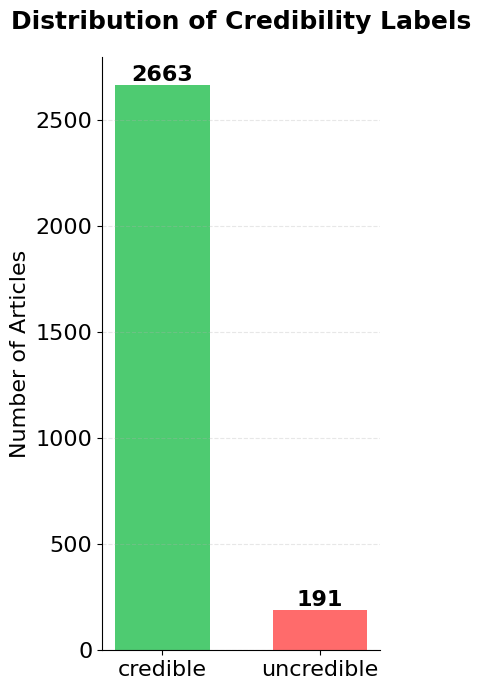

In [42]:
# Overall Credibility Distribution
plt.figure(figsize=(4, 7))  # Increased figure size for better visibility

# Get the counts and create bars
credibility_counts = df_data_exploration['credibility_label'].value_counts()
bars = plt.bar(credibility_counts.index, 
               credibility_counts.values, 
               color=['#4ECB71', '#FF6B6B'],  # Red for uncredible, green for credible
               width=0.6)  # Slightly narrower bars

# Customize the plot
plt.title('Distribution of Credibility Labels', 
          fontsize=18, 
          fontweight='bold', 
          pad=20)
plt.ylabel('Number of Articles', fontsize=16)

# Add counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 
            yval, 
            int(yval), 
            ha='center', 
            va='bottom',
            fontsize=16,
            fontweight='bold')

# Remove top and right spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add subtle grid lines
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Increase font size of x-axis labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Adjust layout
plt.tight_layout()

plt.show()

#### Credibility Distribution by Source

Several different options to display the information

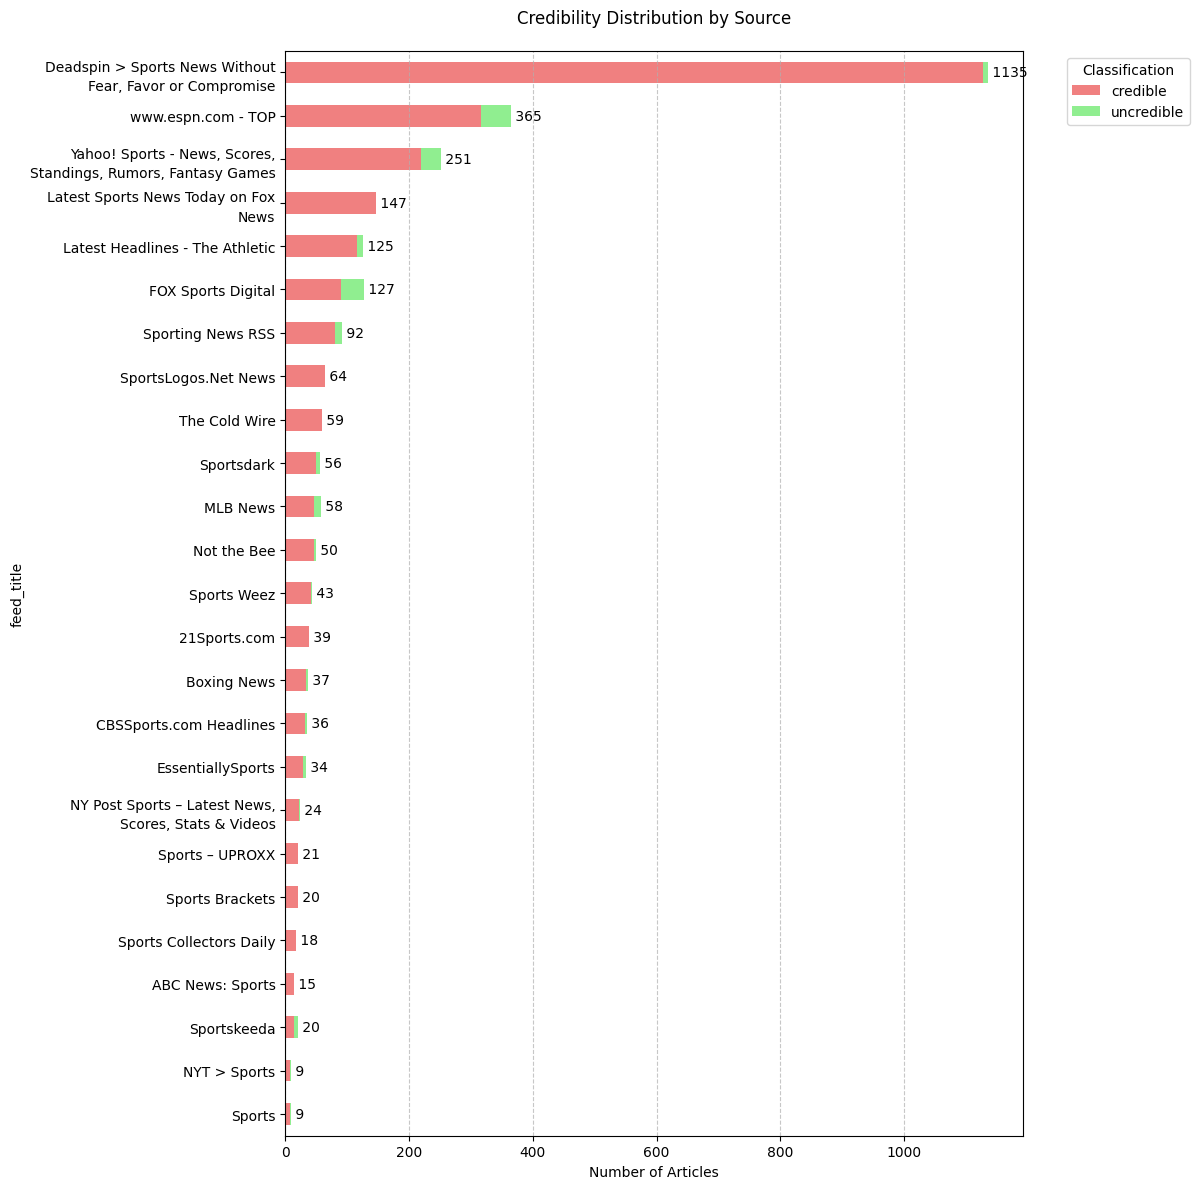

In [5]:
# Create a cleaner horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 12))
# Group and prepare the data
source_credibility = df_data_exploration.groupby('feed_title')['credibility_label'].value_counts().unstack(fill_value=0)
source_credibility = source_credibility.sort_values(by='credible', ascending=True)  # Sort by credible count
# Create the stacked bars
source_credibility.plot(kind='barh', stacked=True, 
                          color=['lightcoral', 'lightgreen'], ax=ax)  # Red for uncredible, green for credible
# Add count labels at the end of each bar
for i in range(len(source_credibility)):
    # Get total count for each source
    total = source_credibility.iloc[i].sum()
    # Position the label just after the end of the stacked bar
    ax.text(total, i, f' {total}', va='center')
#  Customize the plot
plt.title('Credibility Distribution by Source', pad=20, fontsize=12)
plt.xlabel('Number of Articles', fontsize=10)
# Wrap long source names
from textwrap import wrap
labels = ['\n'.join(wrap(label, width=32)) for label in source_credibility.index]
ax.set_yticklabels(labels)
ax.tick_params(axis='y', labelsize=10)  # Reduce font size of labels
# Add legend
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to prevent label cutoff
plt.subplots_adjust(left=0.4, right=0.85)
# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
# Increase spacing between y-axis ticks
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels, linespacing=1.5)  # Increase line spacing between wrapped labels
plt.tight_layout()
plt.show()

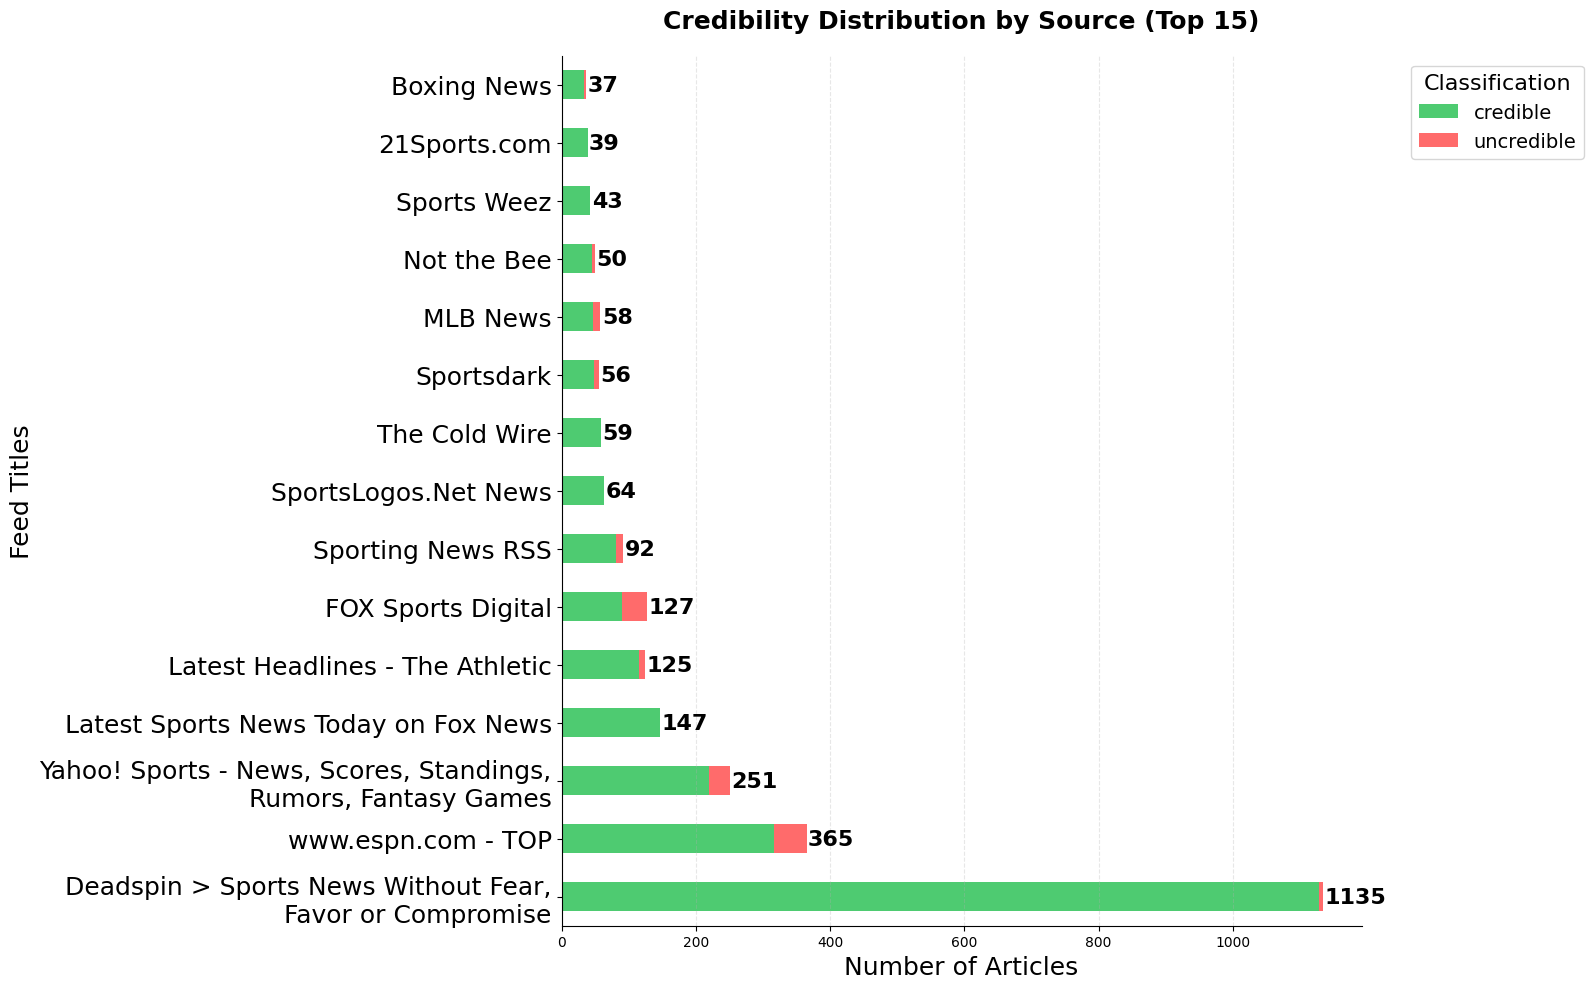

In [33]:
# Create a cleaner horizontal bar chart with larger size
fig, ax = plt.subplots(figsize=(16, 10))  # Increased figure size

# Group and prepare the data
source_credibility = df_data_exploration.groupby('feed_title')['credibility_label'].value_counts().unstack(fill_value=0)
source_credibility = source_credibility.sort_values(by='credible', ascending=False)  # Sort by credible count

# Take only top 15 sources
source_credibility = source_credibility.head(15)

# Create the stacked bars
source_credibility.plot(kind='barh', stacked=True, 
                       color=['#4ECB71', '#FF6B6B'], ax=ax)  # Red for uncredible, green for credible

# Add count labels at the end of each bar
for i in range(len(source_credibility)):
    total = source_credibility.iloc[i].sum()
    ax.text(total + 2, i, f'{total}', va='center', fontsize=16, fontweight='bold')  # Increased font size

# Customize the plot
plt.title('Credibility Distribution by Source (Top 15)', pad=20, fontsize=18, fontweight='bold')
plt.xlabel('Number of Articles', fontsize=18)
plt.ylabel('Feed Titles', fontsize=18)

# Wrap long source names
from textwrap import wrap
labels = ['\n'.join(wrap(label, width=40)) for label in source_credibility.index]
ax.set_yticklabels(labels, fontsize=18)  # Increased font size to match the number of articles label

# Add legend with larger font
plt.legend(title='Classification', 
          bbox_to_anchor=(1.05, 1), 
          loc='upper left',
          fontsize=14,
          title_fontsize=16)

# Adjust layout
plt.subplots_adjust(left=0.4, right=0.85)

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Increase spacing between y-axis ticks
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels, linespacing=1.2)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

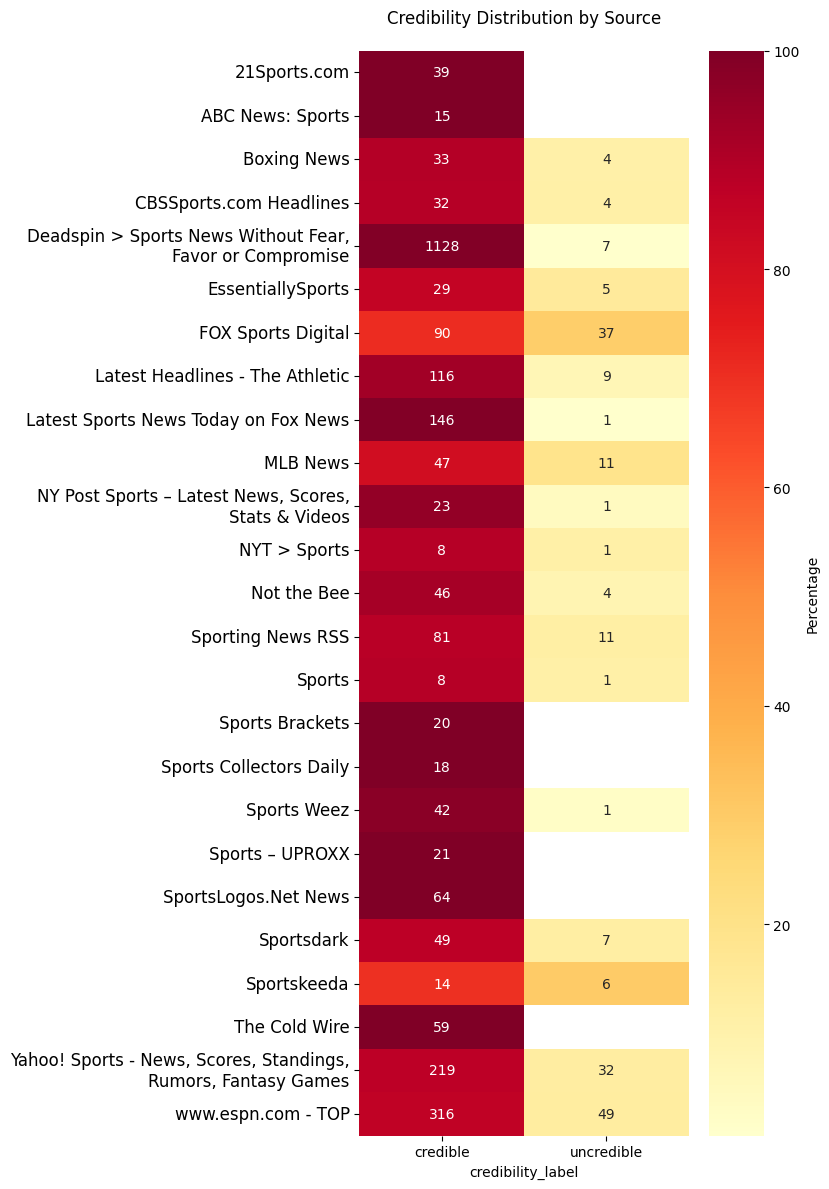

In [6]:
# Create a table with heatmap
plt.figure(figsize=(8, 12))
source_credibility = df_data_exploration.groupby('feed_title')['credibility_label'].value_counts().unstack()
# Calculate percentages for better comparison
source_credibility_pct = source_credibility.div(source_credibility.sum(axis=1), axis=0) * 100
# Wrap feed titles
from textwrap import wrap
wrapped_labels = ['\n'.join(wrap(label, width=40)) for label in source_credibility.index]
# Create heatmap
sns.heatmap(source_credibility_pct, 
           annot=source_credibility.values,  # Show raw counts
           fmt='g',                          # Format as integer
           cmap='YlOrRd',                    # Color scheme
           cbar_kws={'label': 'Percentage'},
           yticklabels=wrapped_labels)
plt.title('Credibility Distribution by Source', pad=20, fontsize=12)
plt.ylabel('')
plt.xticks(rotation=0)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

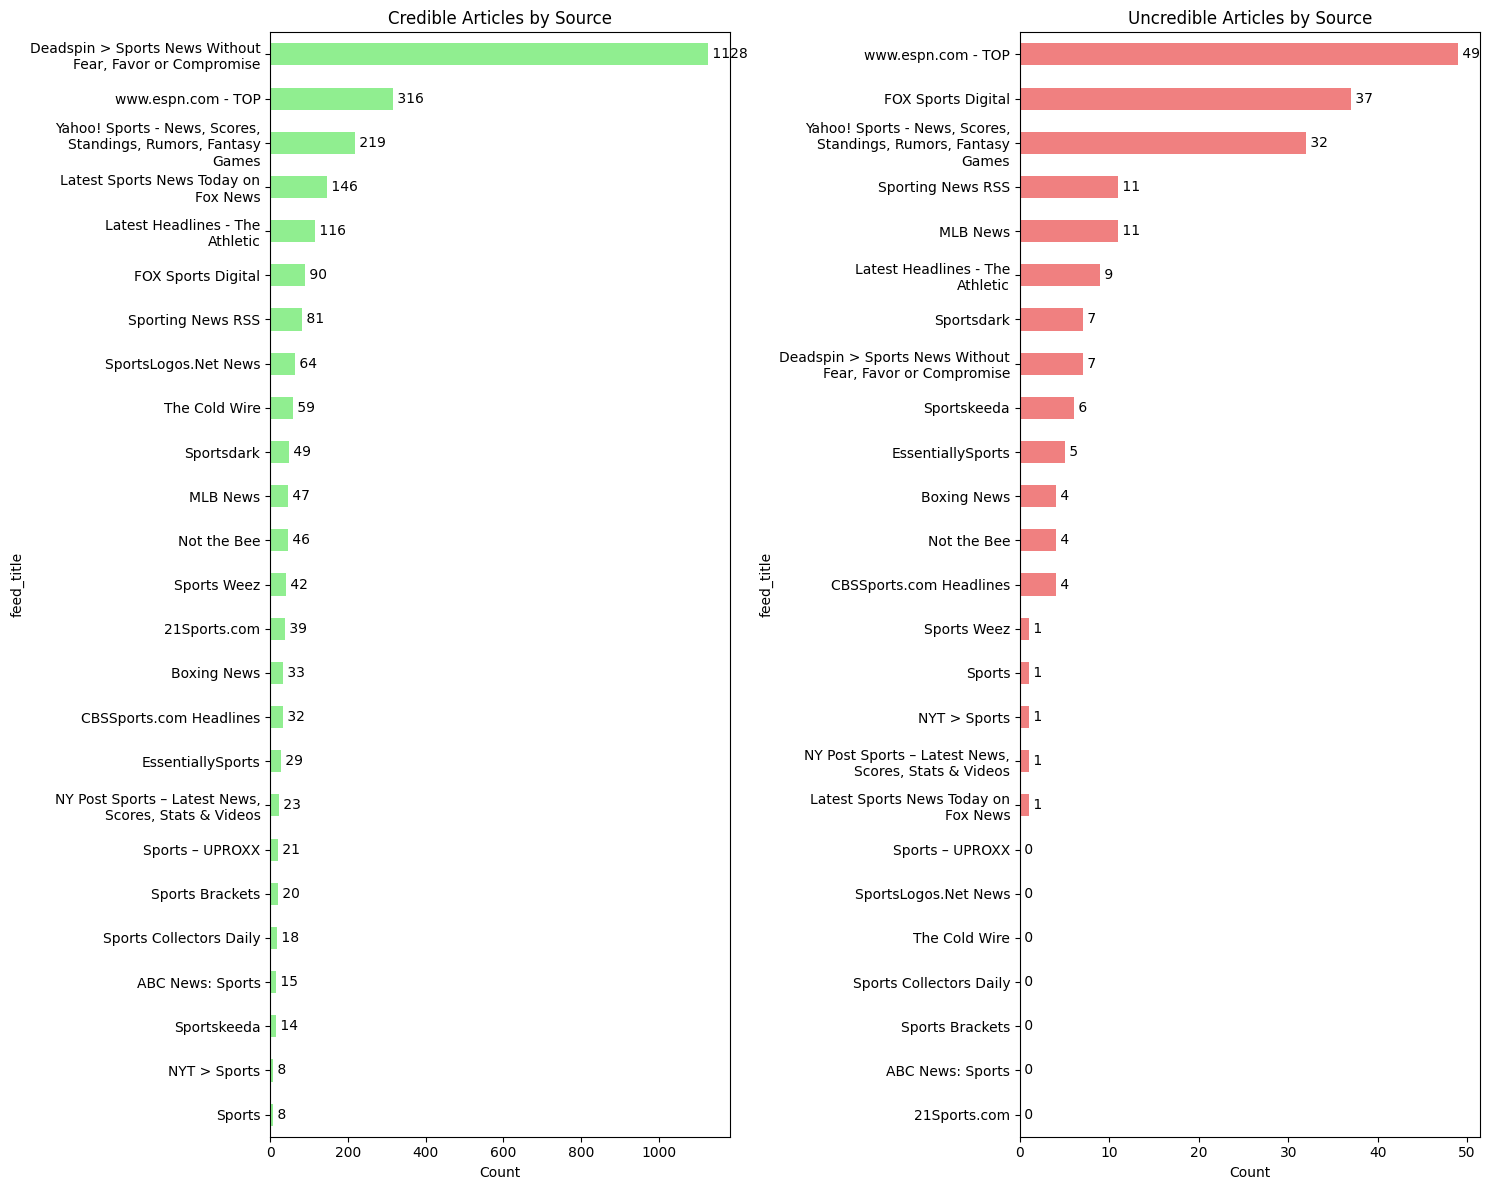

In [7]:
# Create two side-by-side bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 12))
# Credible counts
credible_counts = source_credibility['credible'].fillna(0).sort_values(ascending=True)
credible_counts.plot(kind='barh', ax=ax1, color='lightgreen')
ax1.set_title('Credible Articles by Source')
ax1.set_xlabel('Count')
# Add count labels at the end of each bar
for i in range(len(credible_counts)):
    total = int(credible_counts.iloc[i])
    ax1.text(total, i, f' {total}', va='center')
# Uncredible counts
uncredible_counts = source_credibility['uncredible'].fillna(0).sort_values(ascending=True)
uncredible_counts.plot(kind='barh', ax=ax2, color='lightcoral')
ax2.set_title('Uncredible Articles by Source')
ax2.set_xlabel('Count')
# Add count labels at the end of each bar
for i in range(len(uncredible_counts)):
    total = int(uncredible_counts.iloc[i])
    ax2.text(total, i, f' {total}', va='center')
# Wrap labels for both plots
for ax in [ax1, ax2]:
   labels = ['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()]
   ax.set_yticklabels(labels)
plt.tight_layout()
plt.show()

#### Average Credibility Score by Source

In [8]:
avg_scores = df_data_exploration.groupby('feed_title')['credibility_score'].mean().sort_values()

# Create a DataFrame from the average scores
avg_scores_df = avg_scores.reset_index()
avg_scores_df.columns = ['Feed Title', 'Average Credibility Score']

# Display the table
# print(avg_scores_df)

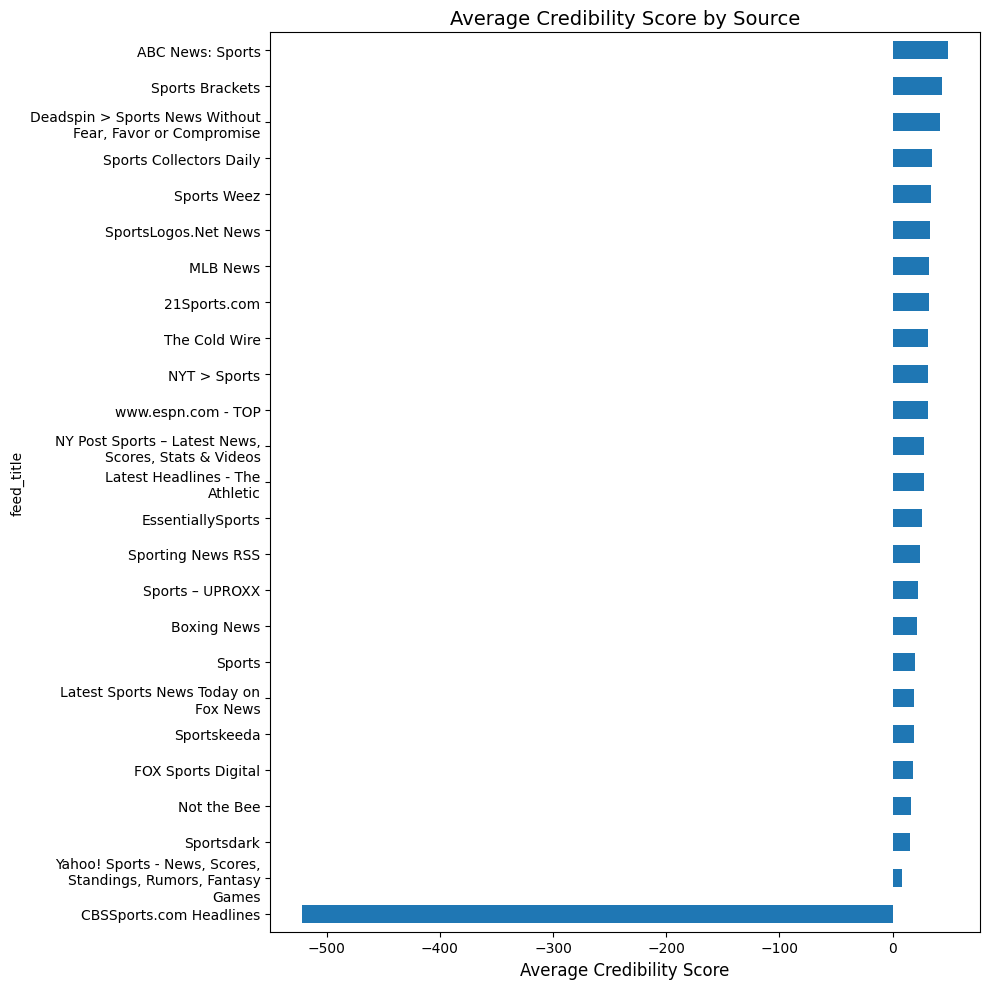

In [9]:
# Average Credibility Score by Source
plt.figure(figsize=(10, 10))

# Wrap feed titles
wrapped_labels = ['\n'.join(wrap(label, width=30)) for label in avg_scores.index]

# Plot the bar chart
avg_scores.plot(kind='barh')

# Set title and labels with increased font size
plt.title('Average Credibility Score by Source', fontsize=14)
plt.xlabel('Average Credibility Score', fontsize=12)

# Set y-tick labels with wrapped text and increased font size
plt.yticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, fontsize=10)

# Limit the y-axis range to exclude extreme outliers
# plt.xlim(-550, 50)  # Adjust this range based on your data

plt.tight_layout()
plt.show()

In [17]:
# Create a DataFrame with multiple statistics for each feed source
stats_df = df_data_exploration.groupby('feed_title').agg({
    'credibility_score': ['mean', 'min', 'max', 'std', 'count'],
    'source_credibility': 'first'  # Add this line to get the source credibility
}).round(2)

# Rename columns for clarity
stats_df.columns = [
    'Avg Score', 
    'Min Score', 
    'Max Score', 
    'Std Dev',
    'Article Count',
    'Source Credibility'  # Add this to column names
]

# Sort by average credibility score
stats_df = stats_df.sort_values('Avg Score', ascending=False)

# Reset index to make feed_title a column
stats_df = stats_df.reset_index()

# Wrap long feed titles
from textwrap import wrap
stats_df['feed_title'] = stats_df['feed_title'].apply(lambda x: '\n'.join(wrap(x, width=40)))

# Display the table using pandas styling
styled_df = stats_df.style\
    .background_gradient(subset=['Avg Score'], cmap='RdYlGn')\
    .format({
        'Avg Score': '{:.2f}',
        'Min Score': '{:.2f}',
        'Max Score': '{:.2f}',
        'Std Dev': '{:.2f}',
        'Article Count': '{:.0f}'
    })\
    .set_properties(**{
        'text-align': 'left',
        'font-size': '11pt',
        'padding': '5px'
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'left'), ('padding', '5px')]},
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold')]}
    ])\
    .set_caption('Feed Source Statistics Ordered by Average Credibility Score')

display(styled_df)

# Save the full DataFrame to a CSV file
stats_df.to_csv('feed_source_statistics_full.csv', index=False)

,feed_title,Avg Score,Min Score,Max Score,Std Dev,Article Count,Source Credibility
0,ABC News: Sports,48.61,39.48,58.16,7.01,15,high
1,Sports Brackets,43.49,35.70,54.38,4.46,20,unknown
2,"Deadspin > Sports News Without Fear, Favor or Compromise",41.88,-295.42,64.38,12.79,1135,high
3,Sports Collectors Daily,35.01,29.48,41.93,5.60,18,unknown
4,Sports Weez,33.54,-20.06,48.16,11.25,43,unknown
5,SportsLogos.Net News,33.27,29.48,48.16,5.04,64,unknown
6,MLB News,32.23,-10.06,58.16,20.13,58,high
7,21Sports.com,31.71,29.48,41.93,4.84,39,unknown
8,The Cold Wire,31.59,29.48,35.70,2.97,59,unknown
9,NYT > Sports,31.02,-49.14,45.70,30.18,9,high


In [11]:
# Summary statistics
print("\nSummary Statistics:")
print("-" * 50)
print("\nOverall Credibility Counts:")
print(df_data_exploration['credibility_label'].value_counts())
print("\nCredibility by Source Type:")
print(df_data_exploration.groupby('source_credibility')['credibility_label'].value_counts().unstack())


Summary Statistics:
--------------------------------------------------

Overall Credibility Counts:
credibility_label
credible      2663
uncredible     191
Name: count, dtype: int64

Credibility by Source Type:
credibility_label   credible  uncredible
source_credibility                      
high                    1765         104
low                      213           5
medium                     8           1
unknown                  677          81


## Train a model using glove and additional features, source split to eval if model can generalize

### Turn each headline into a glove embedding

In [12]:
#article vec is mean of token's embeddings
# Load the GloVe embedding from file into dictionary
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Path to GloVe file
glove_path = 'glove.6B.300d.txt'
embeddings = load_glove_embeddings(glove_path)

# Function to get the embedding of a headline
def get_headline_embedding(headline, glove_model):
    
    words = headline.lower().split()
    word_vectors = [glove_model[word] for word in words if word in glove_model]

    #if no words were found in the model
    if not word_vectors:
         return np.zeros(300,) #return vector of all 0
    
    # Return average of all word vectors
    vector= np.mean(word_vectors, axis=0)
    assert vector.shape == (300,), f"Inconsistent embedding shape: {vector.shape}"
    return vector


FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.300d.txt'

### Prep the data into train and test by source split

In [41]:
from sklearn.model_selection import train_test_split
import numpy as np

def extract_features(headline): #features not in heuristic for labels 
    features= np.array([
        word_count(headline),
        char_count(headline),
        avg_word_length(headline),
        all_capitalized_word_count(headline),
        punctuation_count(headline),
        readability_score(headline),
        count_quotation_pairs(headline),
        variety_of_vocabularity(headline),
        count_sensational_words(headline),
        count_absolute_words(headline),
        objective_score(headline),
        sentiment(headline)
    ])
    return features

In [45]:
data = pd.read_csv('labeled_RSS_posts.csv') #get labeled data

#Split up sources randomly, aka by feed_title
sources = data["feed_title"].unique()
train_sources, test_sources = train_test_split(sources, test_size=0.2, random_state=42)


print(f'train sources: {train_sources}\n')
print(f'test sources: {test_sources}\n')

#Create train and test splits based on sources
train_data = data[data["feed_title"].isin(train_sources)]
test_data = data[data["feed_title"].isin(test_sources)]   ## ADJUST TEST SIZE BASED ON ENTRIES IN EACH OF THESE??

print(f'train_data len: {len(train_data)}') #2,000 ish
print(f'test_data len: {len(test_data)}') # 600 ish

#prep y values- labels 
y_train = (train_data["credibility_label"] == "credible").astype(int).values #1=credible, 0= incredible
print(f'train y data len: {len(y_train)}')

y_test = (test_data["credibility_label"] == "credible").astype(int).values
print(f'test y data len: {len(y_test)}')
# #---------------------------------------

#Apply embeddings and feature calculations to each headline, combine features and glove embeddings
X_train = np.array([
    np.hstack((get_headline_embedding(row["entry_title"], embeddings), extract_features(row["entry_title"])))
    for index, row in train_data.iterrows()
])

# Prepare testing data
X_test = np.array([
    np.hstack((get_headline_embedding(row["entry_title"], embeddings), extract_features(row["entry_title"])))
    for index, row in test_data.iterrows()
])

#print(test_data)

train sources: ['Sports – UPROXX' 'Sports Collectors Daily'
 'Deadspin > Sports News Without Fear, Favor or Compromise'
 'Sports Brackets' 'MLB News' 'ABC News: Sports'
 'NY Post Sports – Latest News, Scores, Stats & Videos'
 'Sporting News RSS' 'NYT > Sports' 'Latest Headlines - The Athletic'
 'The Cold Wire' '21Sports.com' 'Sportsdark' 'EssentiallySports'
 'FOX Sports Digital' 'CBSSports.com Headlines' 'Sports'
 'SportsLogos.Net News' 'Boxing News'
 'Yahoo! Sports - News, Scores, Standings, Rumors, Fantasy Games']

test sources: ['Not the Bee' 'Sports Weez' 'www.espn.com - TOP' 'Sportskeeda'
 'Latest Sports News Today on Fox News']

train_data len: 2229
test_data len: 625
train y data len: 2229
test y data len: 625


In [105]:
# print(len(X_train))
# print(len(X_test))
# print(y_train)
# print(y_test)

### Random Forest model

Accuracy: 0.8976
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.90      0.99      0.95       564

    accuracy                           0.90       625
   macro avg       0.45      0.50      0.47       625
weighted avg       0.81      0.90      0.85       625

Feature Importance:
Glove_Dim_242: 0.0181
Glove_Dim_9: 0.0173
Glove_Dim_21: 0.0173
punctuation_count: 0.0162
Glove_Dim_60: 0.0138
word_count: 0.0133
Glove_Dim_55: 0.0123
Glove_Dim_78: 0.0113
char_count: 0.0101
Glove_Dim_135: 0.0095
Glove_Dim_244: 0.0083
Glove_Dim_145: 0.0080
Glove_Dim_90: 0.0080
Glove_Dim_82: 0.0072
Glove_Dim_275: 0.0072
Glove_Dim_32: 0.0072
Glove_Dim_270: 0.0072
avg_word_length: 0.0069
Glove_Dim_276: 0.0068
Glove_Dim_189: 0.0064
Glove_Dim_66: 0.0058
Glove_Dim_152: 0.0055
Glove_Dim_194: 0.0054
Glove_Dim_176: 0.0054
Glove_Dim_269: 0.0054
Glove_Dim_199: 0.0053
Glove_Dim_8: 0.0052
Glove_Dim_31: 0.0052
Glove_Dim_87: 0.0051
Glove_Dim_33

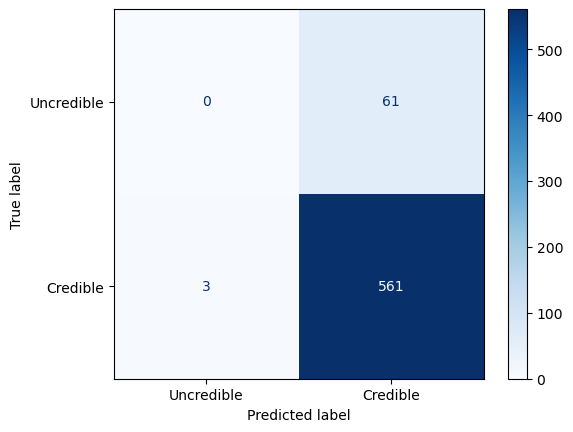

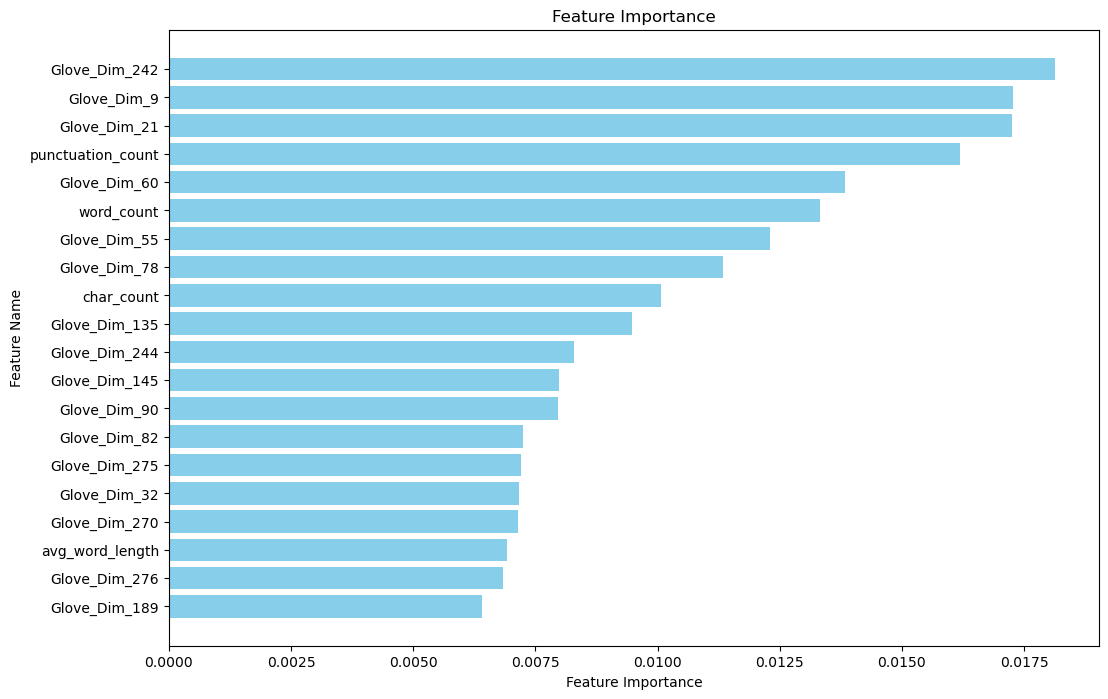

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train) #train


#Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

#add to test data_df the 
test_data1= test_data.copy()
test_data1['True_Label'] = y_test
test_data1['classification_label'] = y_pred
test_data1['Probability_Uncredible'] = y_pred_proba[:, 0]
test_data1['Probability_Credible'] = y_pred_proba[:, 1]
test_data1.to_csv("test_data_with_predictions_model_all_data.csv", index=False)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#---------------
# Compute confusion matrix and display it
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Uncredible", "Credible"])
disp.plot(cmap="Blues")
#-------------------

#Get feature importance scores
importances = model.feature_importances_

# GloVe feature names (calling them Glove_Dim_0 to Glove_Dim_299)
glove_feature_names = [f"Glove_Dim_{i}" for i in range(300)]

#added feature names
additional_feature_names = [
    "word_count", "char_count", "avg_word_length", "all_capitalized_word_count",
    "punctuation_count", "readability_score", "quotation_count", "vocab_variety",
    "sensational_words_count", "absolute_words_count", "objective_score", "sentiment"
]

#Combine GloVe and added feature names
feature_names = glove_feature_names + additional_feature_names

#Pair the feature names with their importance scores
feature_importance = list(zip(feature_names, importances))

#Sort by importance
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

#Display top features
print("Feature Importance:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance:.4f}")
#-----------------
#Plot feature importance

# Sort the feature names and importance
sorted_features = [f[0] for f in feature_importance]
sorted_importances = [f[1] for f in feature_importance]

plt.figure(figsize=(12, 8))
plt.barh(sorted_features[:20], sorted_importances[:20], color='skyblue')  # Top 20 features
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()

#### Class 0 (Uncredible):

True Negatives (0): No "uncredible" samples were correctly classified.

False Positives (61): All "uncredible" samples were misclassified as "credible."
The model completely failed to identify the minority class ("uncredible").


Precision (0.00): Out of all predictions for "uncredible," none were correct.
The model never predicted "uncredible" correctly.

Recall (0.00): Out of 61 actual "uncredible" samples, none were identified.

F1-Score (0.00): Both precision and recall are zero, resulting in an F1-score of zero.


#### Class 1 (Credible):

True Positives (561): Almost all "credible" samples were correctly classified.

False Negatives (3): Only 3 "credible" samples were misclassified as "uncredible."

Precision (0.90): Out of all predictions for "credible," 90% were correct.

Recall (0.99): Out of 564 actual "credible" samples, 99% were identified correctly.

F1-Score (0.95): A high F1-score indicates strong performance for "credible."

### Reduce samples in the credible class to make more balanced
Helps prevent the model from being biased toward the majority class (cred) and forces model to focus on learning the patterns of the minority class (uncred).

Accuracy: 0.8976
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.90      0.99      0.95       564

    accuracy                           0.90       625
   macro avg       0.45      0.50      0.47       625
weighted avg       0.81      0.90      0.85       625

Feature Importance:
Glove_Dim_242: 0.0181
Glove_Dim_9: 0.0173
Glove_Dim_21: 0.0173
punctuation_count: 0.0162
Glove_Dim_60: 0.0138
word_count: 0.0133
Glove_Dim_55: 0.0123
Glove_Dim_78: 0.0113
char_count: 0.0101
Glove_Dim_135: 0.0095
Glove_Dim_244: 0.0083
Glove_Dim_145: 0.0080
Glove_Dim_90: 0.0080
Glove_Dim_82: 0.0072
Glove_Dim_275: 0.0072
Glove_Dim_32: 0.0072
Glove_Dim_270: 0.0072
avg_word_length: 0.0069
Glove_Dim_276: 0.0068
Glove_Dim_189: 0.0064
Glove_Dim_66: 0.0058
Glove_Dim_152: 0.0055
Glove_Dim_194: 0.0054
Glove_Dim_176: 0.0054
Glove_Dim_269: 0.0054
Glove_Dim_199: 0.0053
Glove_Dim_8: 0.0052
Glove_Dim_31: 0.0052
Glove_Dim_87: 0.0051
Glove_Dim_33

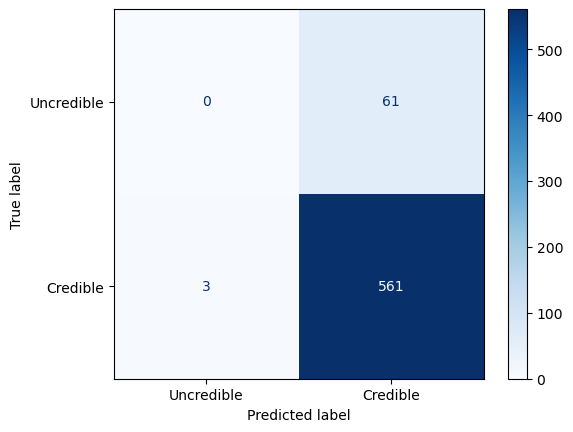

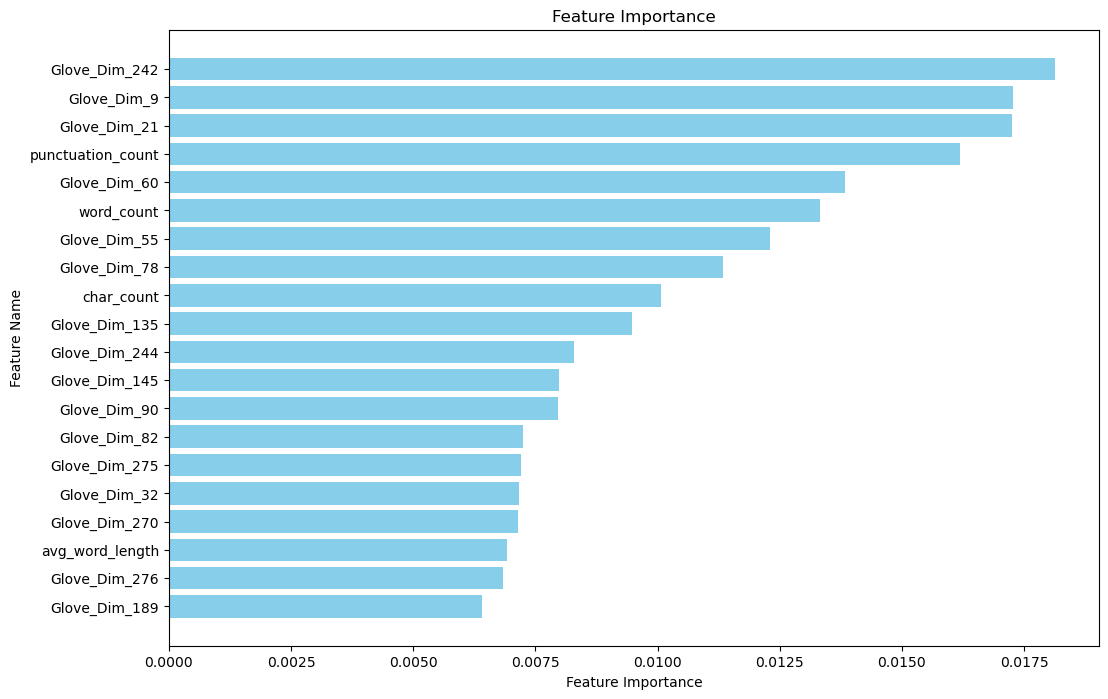

In [47]:
from imblearn.under_sampling import RandomUnderSampler

#Reduce samples in the credible class
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)


model2 = RandomForestClassifier(class_weight="balanced", random_state=42) #if uncredible has fewer samples, its misclassification is penalized more heavily
model2.fit(X_train_balanced, y_train_balanced)


#Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

#add to test data_df the
test_data2= test_data.copy()
test_data2['True_Label'] = y_test
test_data2['classification_label'] = y_pred
test_data2['Probability_Uncredible'] = y_pred_proba[:, 0]
test_data2['Probability_Credible'] = y_pred_proba[:, 1]
test_data2.to_csv("test_data_with_predictions_model_reduced_data.csv", index=False)


# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Uncredible", "Credible"])
disp.plot(cmap="Blues")
#---------------------------------------------------------

#GloVe feature names (e.g., Glove_Dim_0 to Glove_Dim_299)
glove_feature_names = [f"Glove_Dim_{i}" for i in range(300)]

#added feature names
additional_feature_names = [
    "word_count", "char_count", "avg_word_length", "all_capitalized_word_count",
    "punctuation_count", "readability_score", "quotation_count", "vocab_variety",
    "sensational_words_count", "absolute_words_count", "objective_score", "sentiment"
]

#Combine GloVe and added feature names
feature_names = glove_feature_names + additional_feature_names

#Pair the feature names with their importance scores
feature_importance = list(zip(feature_names, importances))

#Sort by importance
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

#Display the top features
print("Feature Importance:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance:.4f}")

#Sort the feature names and importance
sorted_features = [f[0] for f in feature_importance]
sorted_importances = [f[1] for f in feature_importance]


plt.figure(figsize=(12, 8))
plt.barh(sorted_features[:20], sorted_importances[:20], color='skyblue')  # Top 20 features
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()


True Positives (329): Correctly predicted "credible."

True Negatives (45): Correctly predicted "incredible."

False Positives (16): Misclassified "credible" as "incredible."

False Negatives (235): Misclassified "uncredible" as "credible."

#### Class 0 (Uncredible):
Precision (0.16): Out of all predictions for "uncredible," only 16% were correct.
The model has a high number of false positives for "incredible."

Recall (0.74): 74% of the actual "uncredible" samples were identified correctly
This shows the model is reasonably good at detecting "uncredible" samples. 

F1-Score (0.26): low precision brings down the F1-score

#### Class 1 (Credible):
Precision (0.95): Out of all predictions for "credible," 95% were correct.
This indicates the model is good at predicting "credible" samples.

Recall (0.58): Only 58% of the actual "credible" samples were identified correctly.
A significant number of false negatives lower the recall.

F1-Score (0.72): Shows overall good performance for "credible."

### Run model on new data

In [51]:
new_data = pd.read_csv('all_RSS_articles_unlabeled.csv') #get unlabeled new data

#Prep new data
X_new = np.array([
    np.hstack((get_headline_embedding(row["entry_title"], embeddings), extract_features(row["entry_title"])))
    for index, row in new_data.iterrows()
])

new_predictions = model2.predict(X_new)
new_probabilities = model2.predict_proba(X_new)

# Add predictions to the new_data 
new_data['classification_label'] = new_predictions
new_data['Probability_Uncredible'] = new_probabilities[:, 0]
new_data['Probability_Credible'] = new_probabilities[:, 1]

new_data.to_csv("new_data_predictions.csv", index=False)
print(new_data)


              feed_title                                        entry_title  \
0     www.espn.com - TOP  Horns control Aggies, to vie for SEC title in ...   
1     www.espn.com - TOP   Legendary St. John's coach Carnesecca dies at 99   
2     www.espn.com - TOP    Ohio St. police probe pepper spray use in melee   
3     www.espn.com - TOP   Napier berates Gators' flag-planting on FSU logo   
4     www.espn.com - TOP      Shiffrin has abdomen wound, trauma from crash   
...                  ...                                                ...   
4364          Sportsdark  Chelsea captain Reece James speaks out followi...   
4365          Sportsdark  Mourinho eyes Ronaldo reunion, Chelsea want €1...   
4366          Sportsdark  Former NFL head coach Mike Mularkey admits to ...   
4367          Sportsdark  Why Taylor Swift and Travis Kelce can't share ...   
4368          Sportsdark  How the first game of every Man United manager...   

                                             entry_

### Format DF to match DB table

In [53]:
from datetime import datetime
from dateutil import parser

# df['publication_date'] = df['entry_published_date'].apply(lambda x: parser.parse(x).date()) #parse different date formats to date object format
#dbdf = pd.read_csv('test_data_with_predictions_model_all_data.csv') #first model
#dbdf = pd.read_csv('test_data_with_predictions_model_reduced_data.csv') # more balanced model
dbdf = pd.read_csv('new_data_predictions.csv') # more balanced model


dbdf['team_or_player'] = dbdf['entry_title']
dbdf['source'] = dbdf['feed_title']
dbdf['publication_date'] = dbdf['publication_date'] 
dbdf['content'] = dbdf['entry_summary']   
dbdf['trust_score'] = dbdf['Probability_Credible']         
dbdf['classification'] = dbdf['classification_label']       
dbdf['link'] = dbdf['entry_link']

#make a new df in the format of the DB table for easy inserting
sports_DB_df = dbdf[['team_or_player', 'source', 'publication_date', 'content', 'trust_score', 'classification', 'link']]
#save to a new CSV 
sports_DB_df.to_csv('formatted_sports_posts_for_DB.csv', index=False)
print("done")

done


### Insert into Database

In [55]:
username = 'root'  
password = 'password'
host = 'localhost' 
database = 'sports_misinfo_db'

connection = mysql.connector.connect(
    host=host,
    user=username,
    password=password,
    database=database
)

if connection.is_connected():
    print("Connected to the database successfully!")

engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}/{database}", echo=False)

Connected to the database successfully!


#### Use this format to insert into the database

INSERT INTO articles (team_or_player, source, publication_date, content, trust_score, classification, link)
VALUES
('This is a sample title', 'ESPN- top sports', '2024-10-27', 'Yankees article content example.', .85, 'credible', 'https://example.com/article1'),
('Los Angeles Lakers', 'Twitter', '2024-10-27', 'Lakers article content example.', 60.00, 'credible', 'https://example.com/article2');


#### Table fields 
Table Name: articles

Fields: 

     id INT AUTO_INCREMENT PRIMARY KEY,
     
     team_or_player VARCHAR(500), (This will be the article title that we can query- usually includes teams or names in it)
     
     source VARCHAR(500),
     
     publication_date DATE,
     
     content TEXT,
     
     trust_score DECIMAL(5, 2), 
     
     classification ENUM('credible', 'uncredible', 'unknown') DEFAULT 'unknown',

     link VARCHAR(500)

In [57]:
cursor = connection.cursor()
insert_query = """
INSERT INTO articles (team_or_player, source, publication_date, content, trust_score, classification, link)
VALUES (%s, %s, %s, %s, %s, %s, %s)
"""

data = pd.read_csv('formatted_sports_posts_for_DB.csv') # more balanced model

#format data
classification_mapping = {1: 'credible', 0: 'uncredible'}
data['classification'] = data['classification'].map(classification_mapping)
data['content'] = data['content'].fillna("No description available")


for index, row in data.iterrows():
    values = (
        row['team_or_player'],
        row['source'],
        row['publication_date'], 
        row['content'],
        float(row['trust_score']),  
        row['classification'], 
        row['link']
    )
    cursor.execute(insert_query, values)

connection.commit()
cursor.close()
connection.close()
print("Data inserted successfully!")


Data inserted successfully!
